## eur_d

In [1]:
import warnings
warnings.filterwarnings("ignore") 
import os
import time
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.common import ListDataset
from gluonts.evaluation import Evaluator
from gluonts.evaluation import make_evaluation_predictions
from gluonts.model.forecast_generator import DistributionForecastGenerator
from gluonts.torch.distributions import StudentTOutput
from gluonts.torch.modules.loss import NegativeLogLikelihood
from gluonts.torch import DeepAREstimator
from gluonts.torch import SimpleFeedForwardEstimator
from gluonts.torch import TemporalFusionTransformerEstimator
from gluonts.torch import WaveNetEstimator
from gluonts.torch import DeepNPTSEstimator

from sklearn.preprocessing import MinMaxScaler

import optuna

from matplotlib import rcParams
rcParams ['figure.figsize'] = 25, 8
plt.rcParams['font.size'] = 14
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 18 

%load_ext autoreload
%autoreload 2

In [2]:
# Carregar o arquivo
df = pd.read_excel('oil_daily.xlsx')

# Separar a coluna 'date' para evitar escalá-la
dates = df['date']
df_numeric = df.drop(columns=['date'])

# Aplicar o scaler apenas nas colunas numéricas
scaler = MinMaxScaler()
df_pre = pd.DataFrame(scaler.fit_transform(df_numeric), columns=df_numeric.columns)

# Adicionar de volta a coluna 'date'
df_pre['date'] = dates

# Filtrando apenas as colunas relevantes e removendo os NaN
ddf = df_pre[['date', 'eur_d_diff']].dropna()

# Preparando os dados para o ListDataset
df_input = ddf['eur_d_diff'].to_numpy()
df_input = df_input.reshape(1, -1)
prediction_length = 300
freq = "D"
start_ds = ddf["date"].min()
start = pd.Period(start_ds, freq=freq)

# Conjunto de treino: remove a última janela de comprimento "prediction_length", adiciona os campos "target" e "start"
train_ds = ListDataset(
    [{"target": x, "start": start} for x in df_input[:, :-prediction_length]],
    freq=freq,
)

# Conjunto de teste: usa o dataset inteiro, adiciona os campos "target" e "start"
test_ds = ListDataset(
    [{"target": x, "start": start} for x in df_input],
    freq=freq,
)

# Construindo um index para utilização nos gráficos
df_pre = df_pre.dropna()
df_pre.set_index('date', inplace=True)

print("Dataset preparado com sucesso!")

Dataset preparado com sucesso!


In [3]:
# Criar um DataFrame vazio para armazenar os resultados
columns = ['Modelo', 'TIME', 'NRMSE', 'SMAPE', 'MASE']
result_eur_d = pd.DataFrame([], columns=columns)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2042 entries, 0 to 2041
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        2042 non-null   datetime64[ns]
 1   wti_d       2042 non-null   float64       
 2   eur_d       2042 non-null   float64       
 3   wor_d       2042 non-null   float64       
 4   wti_d_diff  2042 non-null   float64       
 5   eur_d_diff  2042 non-null   float64       
 6   wor_d_diff  2042 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 111.8 KB


## SFF

In [5]:
str_time_ssf = time.time()

SSFModel = SimpleFeedForwardEstimator(
                                context_length=prediction_length,
                                prediction_length=prediction_length,
                                lr=1e-2,
                                weight_decay=1e-8,
                                batch_size=24,
                                distr_output= StudentTOutput(),
                                loss= NegativeLogLikelihood(),                                
                                batch_norm=False,
                                num_batches_per_epoch=50,                                                             
                                trainer_kwargs={"max_epochs": 50, "gradient_clip_val": 8.0}
                                )

#Predição do modelo
ssf = SSFModel.train(train_ds)

# Evolução do modelo
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,  # test dataset
    predictor=ssf,  # predictor
    num_samples=prediction_length,  # number of sample paths we want for evaluation
)

forecasts = list(forecast_it)
tss = list(ts_it)

evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts))

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti SUPER') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                   | Params
-------------------------------------------------
0 | model | SimpleFeedForwardModel | 132 K 
-------------------------------------------------
132 K     Trainable params
0         Non-trainable params
132 K     Total params
0.528     Total estimated model params size (MB)


Epoch 0: |          | 50/? [00:01<00:00, 42.11it/s, v_num=4600, train_loss=0.0706]

Epoch 0, global step 50: 'train_loss' reached 0.07056 (best 0.07056), saving model to 'd:\\st_gluonts\\GluonTSProj\\lightning_logs\\version_4600\\checkpoints\\epoch=0-step=50.ckpt' as top 1


Epoch 1: |          | 50/? [00:00<00:00, 109.04it/s, v_num=4600, train_loss=-.890] 

Epoch 1, global step 100: 'train_loss' reached -0.88986 (best -0.88986), saving model to 'd:\\st_gluonts\\GluonTSProj\\lightning_logs\\version_4600\\checkpoints\\epoch=1-step=100.ckpt' as top 1


Epoch 2: |          | 50/? [00:00<00:00, 102.91it/s, v_num=4600, train_loss=-1.02]

Epoch 2, global step 150: 'train_loss' reached -1.01975 (best -1.01975), saving model to 'd:\\st_gluonts\\GluonTSProj\\lightning_logs\\version_4600\\checkpoints\\epoch=2-step=150.ckpt' as top 1


Epoch 3: |          | 50/? [00:00<00:00, 105.84it/s, v_num=4600, train_loss=-1.25]

Epoch 3, global step 200: 'train_loss' reached -1.24917 (best -1.24917), saving model to 'd:\\st_gluonts\\GluonTSProj\\lightning_logs\\version_4600\\checkpoints\\epoch=3-step=200.ckpt' as top 1


Epoch 4: |          | 50/? [00:00<00:00, 100.14it/s, v_num=4600, train_loss=-1.35]

Epoch 4, global step 250: 'train_loss' reached -1.34755 (best -1.34755), saving model to 'd:\\st_gluonts\\GluonTSProj\\lightning_logs\\version_4600\\checkpoints\\epoch=4-step=250.ckpt' as top 1


Epoch 5: |          | 50/? [00:00<00:00, 105.53it/s, v_num=4600, train_loss=-.969]

Epoch 5, global step 300: 'train_loss' was not in top 1


Epoch 6: |          | 50/? [00:00<00:00, 107.87it/s, v_num=4600, train_loss=-1.03]

Epoch 6, global step 350: 'train_loss' was not in top 1


Epoch 7: |          | 50/? [00:00<00:00, 101.07it/s, v_num=4600, train_loss=-1.43]

Epoch 7, global step 400: 'train_loss' reached -1.43474 (best -1.43474), saving model to 'd:\\st_gluonts\\GluonTSProj\\lightning_logs\\version_4600\\checkpoints\\epoch=7-step=400.ckpt' as top 1


Epoch 8: |          | 50/? [00:00<00:00, 111.61it/s, v_num=4600, train_loss=-1.20]

Epoch 8, global step 450: 'train_loss' was not in top 1


Epoch 9: |          | 50/? [00:00<00:00, 110.40it/s, v_num=4600, train_loss=-1.50]

Epoch 9, global step 500: 'train_loss' reached -1.49627 (best -1.49627), saving model to 'd:\\st_gluonts\\GluonTSProj\\lightning_logs\\version_4600\\checkpoints\\epoch=9-step=500.ckpt' as top 1


Epoch 10: |          | 50/? [00:00<00:00, 108.15it/s, v_num=4600, train_loss=-1.47]

Epoch 10, global step 550: 'train_loss' was not in top 1


Epoch 11: |          | 50/? [00:00<00:00, 108.90it/s, v_num=4600, train_loss=-1.40]

Epoch 11, global step 600: 'train_loss' was not in top 1


Epoch 12: |          | 50/? [00:00<00:00, 102.14it/s, v_num=4600, train_loss=-1.50]

Epoch 12, global step 650: 'train_loss' reached -1.49701 (best -1.49701), saving model to 'd:\\st_gluonts\\GluonTSProj\\lightning_logs\\version_4600\\checkpoints\\epoch=12-step=650.ckpt' as top 1


Epoch 13: |          | 50/? [00:00<00:00, 96.32it/s, v_num=4600, train_loss=-1.51] 

Epoch 13, global step 700: 'train_loss' reached -1.51029 (best -1.51029), saving model to 'd:\\st_gluonts\\GluonTSProj\\lightning_logs\\version_4600\\checkpoints\\epoch=13-step=700.ckpt' as top 1


Epoch 14: |          | 50/? [00:00<00:00, 109.20it/s, v_num=4600, train_loss=-1.63]

Epoch 14, global step 750: 'train_loss' reached -1.63138 (best -1.63138), saving model to 'd:\\st_gluonts\\GluonTSProj\\lightning_logs\\version_4600\\checkpoints\\epoch=14-step=750.ckpt' as top 1


Epoch 15: |          | 50/? [00:00<00:00, 105.90it/s, v_num=4600, train_loss=-1.47]

Epoch 15, global step 800: 'train_loss' was not in top 1


Epoch 16: |          | 50/? [00:00<00:00, 109.74it/s, v_num=4600, train_loss=-1.54]

Epoch 16, global step 850: 'train_loss' was not in top 1


Epoch 17: |          | 50/? [00:00<00:00, 106.71it/s, v_num=4600, train_loss=-1.31]

Epoch 17, global step 900: 'train_loss' was not in top 1


Epoch 18: |          | 50/? [00:00<00:00, 108.68it/s, v_num=4600, train_loss=-1.28]

Epoch 18, global step 950: 'train_loss' was not in top 1


Epoch 19: |          | 50/? [00:00<00:00, 101.93it/s, v_num=4600, train_loss=-1.49]

Epoch 19, global step 1000: 'train_loss' was not in top 1


Epoch 20: |          | 50/? [00:00<00:00, 100.75it/s, v_num=4600, train_loss=-1.60]

Epoch 20, global step 1050: 'train_loss' was not in top 1


Epoch 21: |          | 50/? [00:00<00:00, 105.41it/s, v_num=4600, train_loss=-1.61]

Epoch 21, global step 1100: 'train_loss' was not in top 1


Epoch 22: |          | 50/? [00:00<00:00, 99.93it/s, v_num=4600, train_loss=-1.54] 

Epoch 22, global step 1150: 'train_loss' was not in top 1


Epoch 23: |          | 50/? [00:00<00:00, 98.58it/s, v_num=4600, train_loss=-1.49]

Epoch 23, global step 1200: 'train_loss' was not in top 1


Epoch 24: |          | 50/? [00:00<00:00, 93.36it/s, v_num=4600, train_loss=-1.44]

Epoch 24, global step 1250: 'train_loss' was not in top 1


Epoch 25: |          | 50/? [00:00<00:00, 100.51it/s, v_num=4600, train_loss=-1.56]

Epoch 25, global step 1300: 'train_loss' was not in top 1


Epoch 26: |          | 50/? [00:00<00:00, 83.45it/s, v_num=4600, train_loss=-1.53] 

Epoch 26, global step 1350: 'train_loss' was not in top 1


Epoch 27: |          | 50/? [00:00<00:00, 92.48it/s, v_num=4600, train_loss=-1.65]

Epoch 27, global step 1400: 'train_loss' reached -1.64593 (best -1.64593), saving model to 'd:\\st_gluonts\\GluonTSProj\\lightning_logs\\version_4600\\checkpoints\\epoch=27-step=1400.ckpt' as top 1


Epoch 28: |          | 50/? [00:00<00:00, 93.59it/s, v_num=4600, train_loss=-1.57]

Epoch 28, global step 1450: 'train_loss' was not in top 1


Epoch 29: |          | 50/? [00:00<00:00, 94.09it/s, v_num=4600, train_loss=-1.59]

Epoch 29, global step 1500: 'train_loss' was not in top 1


Epoch 30: |          | 50/? [00:00<00:00, 98.38it/s, v_num=4600, train_loss=-1.65]

Epoch 30, global step 1550: 'train_loss' reached -1.65259 (best -1.65259), saving model to 'd:\\st_gluonts\\GluonTSProj\\lightning_logs\\version_4600\\checkpoints\\epoch=30-step=1550.ckpt' as top 1


Epoch 31: |          | 50/? [00:00<00:00, 94.66it/s, v_num=4600, train_loss=-1.58]

Epoch 31, global step 1600: 'train_loss' was not in top 1


Epoch 32: |          | 50/? [00:00<00:00, 102.66it/s, v_num=4600, train_loss=-1.62]

Epoch 32, global step 1650: 'train_loss' was not in top 1


Epoch 33: |          | 50/? [00:00<00:00, 99.76it/s, v_num=4600, train_loss=-1.57] 

Epoch 33, global step 1700: 'train_loss' was not in top 1


Epoch 34: |          | 50/? [00:00<00:00, 104.19it/s, v_num=4600, train_loss=-1.60]

Epoch 34, global step 1750: 'train_loss' was not in top 1


Epoch 35: |          | 50/? [00:00<00:00, 105.29it/s, v_num=4600, train_loss=-1.66]

Epoch 35, global step 1800: 'train_loss' reached -1.66051 (best -1.66051), saving model to 'd:\\st_gluonts\\GluonTSProj\\lightning_logs\\version_4600\\checkpoints\\epoch=35-step=1800.ckpt' as top 1


Epoch 36: |          | 50/? [00:00<00:00, 107.73it/s, v_num=4600, train_loss=-1.55]

Epoch 36, global step 1850: 'train_loss' was not in top 1


Epoch 37: |          | 50/? [00:00<00:00, 106.98it/s, v_num=4600, train_loss=-1.60]

Epoch 37, global step 1900: 'train_loss' was not in top 1


Epoch 38: |          | 50/? [00:00<00:00, 107.54it/s, v_num=4600, train_loss=-1.58]

Epoch 38, global step 1950: 'train_loss' was not in top 1


Epoch 39: |          | 50/? [00:00<00:00, 101.42it/s, v_num=4600, train_loss=-1.52]

Epoch 39, global step 2000: 'train_loss' was not in top 1


Epoch 40: |          | 50/? [00:00<00:00, 105.88it/s, v_num=4600, train_loss=-1.62]

Epoch 40, global step 2050: 'train_loss' was not in top 1


Epoch 41: |          | 50/? [00:00<00:00, 111.21it/s, v_num=4600, train_loss=-1.68]

Epoch 41, global step 2100: 'train_loss' reached -1.67794 (best -1.67794), saving model to 'd:\\st_gluonts\\GluonTSProj\\lightning_logs\\version_4600\\checkpoints\\epoch=41-step=2100.ckpt' as top 1


Epoch 42: |          | 50/? [00:00<00:00, 102.38it/s, v_num=4600, train_loss=-1.66]

Epoch 42, global step 2150: 'train_loss' was not in top 1


Epoch 43: |          | 50/? [00:00<00:00, 97.27it/s, v_num=4600, train_loss=-1.71] 

Epoch 43, global step 2200: 'train_loss' reached -1.71379 (best -1.71379), saving model to 'd:\\st_gluonts\\GluonTSProj\\lightning_logs\\version_4600\\checkpoints\\epoch=43-step=2200.ckpt' as top 1


Epoch 44: |          | 50/? [00:00<00:00, 99.20it/s, v_num=4600, train_loss=-1.65] 

Epoch 44, global step 2250: 'train_loss' was not in top 1


Epoch 45: |          | 50/? [00:00<00:00, 100.15it/s, v_num=4600, train_loss=-1.62]

Epoch 45, global step 2300: 'train_loss' was not in top 1


Epoch 46: |          | 50/? [00:00<00:00, 104.54it/s, v_num=4600, train_loss=-1.69]

Epoch 46, global step 2350: 'train_loss' was not in top 1


Epoch 47: |          | 50/? [00:00<00:00, 98.66it/s, v_num=4600, train_loss=-1.65] 

Epoch 47, global step 2400: 'train_loss' was not in top 1


Epoch 48: |          | 50/? [00:00<00:00, 88.82it/s, v_num=4600, train_loss=-1.72] 

Epoch 48, global step 2450: 'train_loss' reached -1.72101 (best -1.72101), saving model to 'd:\\st_gluonts\\GluonTSProj\\lightning_logs\\version_4600\\checkpoints\\epoch=48-step=2450.ckpt' as top 1


Epoch 49: |          | 50/? [00:00<00:00, 81.31it/s, v_num=4600, train_loss=-1.64]

Epoch 49, global step 2500: 'train_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: |          | 50/? [00:00<00:00, 80.39it/s, v_num=4600, train_loss=-1.64]


Running evaluation: 1it [00:00, 18.92it/s]


In [6]:
time_ssf = time.time() - str_time_ssf
nrmse_ssf = agg_metrics['NRMSE']
smape_ssf = agg_metrics['sMAPE']
mase_ssf = agg_metrics['MASE']

print(nrmse_ssf)
print(smape_ssf)
print(mase_ssf)
print(time_ssf)

result_eur_d.loc[len(result_eur_d)] = [
    'SSF',time_ssf, nrmse_ssf, smape_ssf, mase_ssf
]

0.04955426456776895
0.039425287246704105
1.6267267665148966
32.91106986999512


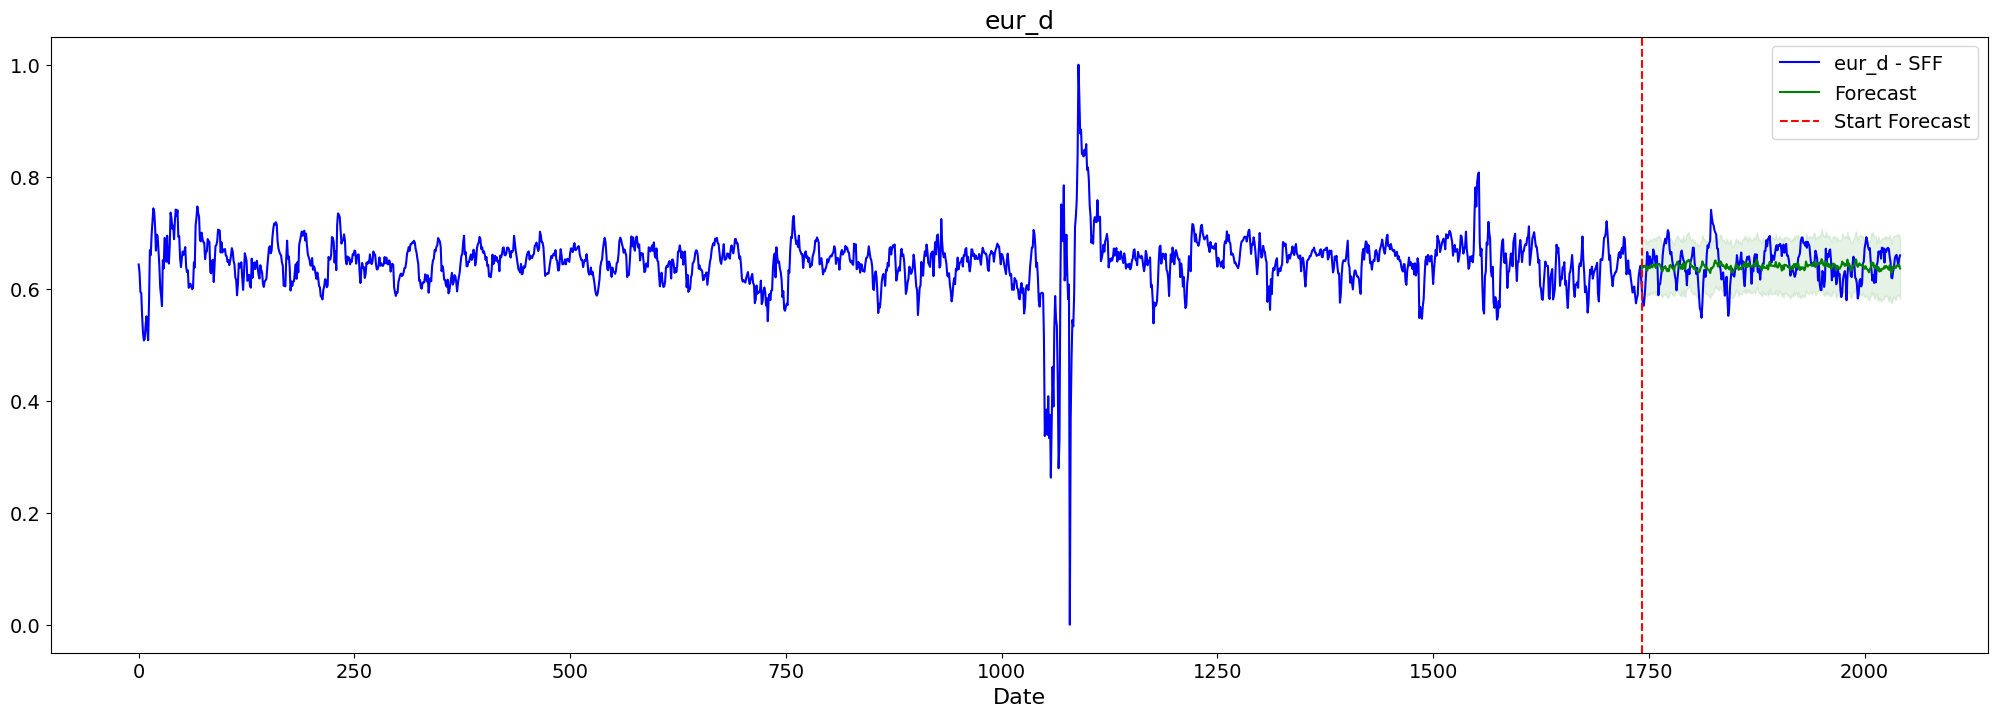

In [7]:
# Gráfico - Série Completa
ts = tss[0]
forecast = forecasts[0]

# Convertendo os índices para Timestamp se eles forem Period
ts_index = df.index.to_timestamp() if isinstance(df.index, pd.PeriodIndex) else df.index

# A previsão começa imediatamente após o último ponto de dados de teste
forecast_start_date = df.index[-prediction_length]

# Aqui estamos assumindo que ts_index é um pandas DatetimeIndex e ts.values são os valores correspondentes.
ts_index_from_forecast = ts_index[ts_index >= forecast_start_date]
ts_values_from_forecast = ts.values[ts_index >= forecast_start_date]

# Plotagem dos dados reais (treino + teste)
plt.figure(figsize=(25, 8))
plt.plot(ts_index, ts.values, label='eur_d - SFF', color='blue')

# Plotagem das previsões
prediction_intervals = (50.0, 90.0)
for pi in prediction_intervals:
    low, high = forecast.quantile(0.01 * (100 - pi)), forecast.quantile(0.01 * pi)
    plt.fill_between(
        ts_index_from_forecast,
        low,
        high,
        alpha=0.1,
        color="g"
    )

plt.plot(ts_index_from_forecast, forecast.mean, label='Forecast', color='g')

# Linha vertical para indicar o início da previsão
plt.axvline(forecast_start_date, color='r', linestyle='--', label='Start Forecast')

plt.title('eur_d')
plt.xlabel('Date')
#plt.ylabel('Valor')
plt.legend()
plt.show()

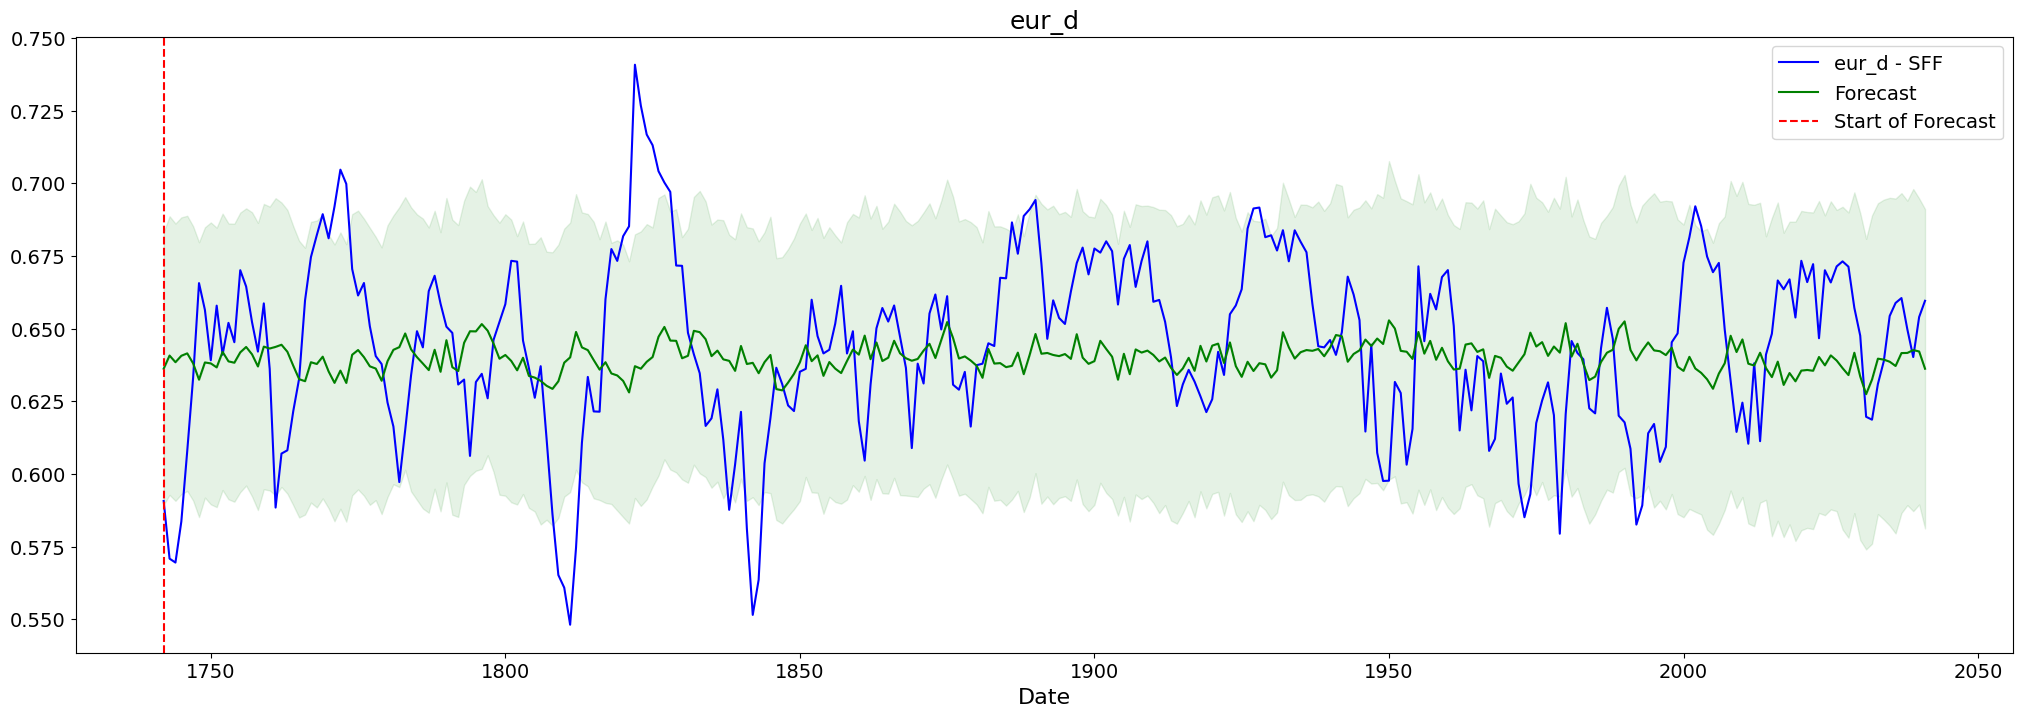

In [8]:
# Gráfico - Forecast
ts = tss[0]
forecast = forecasts[0]

# Convertendo os índices para Timestamp se eles forem Period
ts_index = df.index.to_timestamp() if isinstance(df.index, pd.PeriodIndex) else df.index

# A previsão começa imediatamente após o último ponto de dados de teste
forecast_start_date = df.index[-prediction_length]

# Restringir ts_index e ts.values para o período a partir de forecast_start_date
# Aqui estamos assumindo que ts_index é um pandas DatetimeIndex e ts.values são os valores correspondentes.
ts_index_from_forecast = ts_index[ts_index >= forecast_start_date]
ts_values_from_forecast = ts.values[ts_index >= forecast_start_date]

# Plotagem dos dados reais (treino + teste) a partir de forecast_start_date
plt.figure(figsize=(25, 8))
plt.plot(ts_index_from_forecast, ts_values_from_forecast, label='eur_d - SFF', color='blue')

# Plotagem das previsões
prediction_intervals = (50.0, 90.0)
for pi in prediction_intervals:
    low, high = forecast.quantile(0.01 * (100 - pi)), forecast.quantile(0.01 * pi)
    plt.fill_between(
        ts_index_from_forecast,
        low,
        high,
        alpha=0.1,
        color="g"
    )

plt.plot(ts_index_from_forecast, forecast.mean, label='Forecast', color='g')

# Linha vertical para indicar o início da previsão
plt.axvline(forecast_start_date, color='r', linestyle='--', label='Start of Forecast')

plt.title('eur_d')
plt.xlabel('Date')
plt.legend()
plt.show()

## TFT

In [9]:
str_time_tft = time.time()

TFTModel = TemporalFusionTransformerEstimator(
                    freq="D",
                    context_length=prediction_length,
                    prediction_length=prediction_length,
                    num_heads=8,
                    hidden_dim=24,
                    variable_dim=24,
                    lr=1e-2,
                    weight_decay=1e-2,
                    dropout_rate=0.1,   
                    patience=8,
                    batch_size=24,
                    num_batches_per_epoch=50,
                    trainer_kwargs={"max_epochs": 50, "gradient_clip_val": 8.0}
                    )

#Predição do modelo
tft = TFTModel.train(train_ds)

# Evolução do modelo
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,  # test dataset
    predictor=tft,  # predictor
    num_samples=prediction_length,  # number of sample paths we want for evaluation
)

forecasts = list(forecast_it)
tss = list(ts_it)

evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts))

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                           | Params | In sizes                                                                                 | Out sizes  
------------------------------------------------------------------------------------------------------------------------------------------------------------------
0 | model | TemporalFusionTransformerModel | 62.9 K | [[1, 300], [1, 300], [1, 1], [1, 1], [1, 600, 3], [1, 600, 0], [1, 300, 0], [1, 300, 0]] | [1, 9, 300]
------------------------------------------------------------------------------------------------------------------------------------------------------------------
62.9 K    Trainable params
0         Non-trainable params
62.9 K    Total params
0.252     Total estimated model params size (MB)


Epoch 0: |          | 50/? [00:03<00:00, 13.58it/s, v_num=4601, train_loss=0.253]

Epoch 0, global step 50: 'train_loss' reached 0.25300 (best 0.25300), saving model to 'd:\\st_gluonts\\GluonTSProj\\lightning_logs\\version_4601\\checkpoints\\epoch=0-step=50.ckpt' as top 1


Epoch 1: |          | 50/? [00:03<00:00, 15.20it/s, v_num=4601, train_loss=0.242]

Epoch 1, global step 100: 'train_loss' reached 0.24217 (best 0.24217), saving model to 'd:\\st_gluonts\\GluonTSProj\\lightning_logs\\version_4601\\checkpoints\\epoch=1-step=100.ckpt' as top 1


Epoch 2: |          | 50/? [00:03<00:00, 14.76it/s, v_num=4601, train_loss=0.238]

Epoch 2, global step 150: 'train_loss' reached 0.23755 (best 0.23755), saving model to 'd:\\st_gluonts\\GluonTSProj\\lightning_logs\\version_4601\\checkpoints\\epoch=2-step=150.ckpt' as top 1


Epoch 3: |          | 50/? [00:03<00:00, 14.43it/s, v_num=4601, train_loss=0.239]

Epoch 3, global step 200: 'train_loss' was not in top 1


Epoch 4: |          | 50/? [00:03<00:00, 13.37it/s, v_num=4601, train_loss=0.246]

Epoch 4, global step 250: 'train_loss' was not in top 1


Epoch 5: |          | 50/? [00:03<00:00, 13.09it/s, v_num=4601, train_loss=0.246]

Epoch 5, global step 300: 'train_loss' was not in top 1


Epoch 6: |          | 50/? [00:03<00:00, 14.60it/s, v_num=4601, train_loss=0.258]

Epoch 6, global step 350: 'train_loss' was not in top 1


Epoch 7: |          | 50/? [00:03<00:00, 15.08it/s, v_num=4601, train_loss=0.240]

Epoch 7, global step 400: 'train_loss' was not in top 1


Epoch 8: |          | 50/? [00:03<00:00, 14.83it/s, v_num=4601, train_loss=0.244]

Epoch 8, global step 450: 'train_loss' was not in top 1


Epoch 9: |          | 50/? [00:03<00:00, 14.52it/s, v_num=4601, train_loss=0.253]

Epoch 9, global step 500: 'train_loss' was not in top 1


Epoch 10: |          | 50/? [00:03<00:00, 14.60it/s, v_num=4601, train_loss=0.245]

Epoch 10, global step 550: 'train_loss' was not in top 1


Epoch 11: |          | 50/? [00:03<00:00, 15.11it/s, v_num=4601, train_loss=0.244]

Epoch 11, global step 600: 'train_loss' was not in top 1


Epoch 12: |          | 50/? [00:03<00:00, 14.90it/s, v_num=4601, train_loss=0.239]

Epoch 12, global step 650: 'train_loss' was not in top 1


Epoch 13: |          | 50/? [00:03<00:00, 14.49it/s, v_num=4601, train_loss=0.243]

Epoch 13, global step 700: 'train_loss' was not in top 1


Epoch 14: |          | 50/? [00:03<00:00, 14.41it/s, v_num=4601, train_loss=0.260]

Epoch 14, global step 750: 'train_loss' was not in top 1


Epoch 15: |          | 50/? [00:03<00:00, 14.28it/s, v_num=4601, train_loss=0.240]

Epoch 15, global step 800: 'train_loss' was not in top 1


Epoch 16: |          | 50/? [00:03<00:00, 14.77it/s, v_num=4601, train_loss=0.240]

Epoch 16, global step 850: 'train_loss' was not in top 1


Epoch 17: |          | 50/? [00:03<00:00, 14.86it/s, v_num=4601, train_loss=0.240]

Epoch 17, global step 900: 'train_loss' was not in top 1


Epoch 18: |          | 50/? [00:03<00:00, 14.64it/s, v_num=4601, train_loss=0.240]

Epoch 18, global step 950: 'train_loss' was not in top 1


Epoch 19: |          | 50/? [00:03<00:00, 14.59it/s, v_num=4601, train_loss=0.237]

Epoch 19, global step 1000: 'train_loss' reached 0.23662 (best 0.23662), saving model to 'd:\\st_gluonts\\GluonTSProj\\lightning_logs\\version_4601\\checkpoints\\epoch=19-step=1000.ckpt' as top 1


Epoch 20: |          | 50/? [00:03<00:00, 14.62it/s, v_num=4601, train_loss=0.237]

Epoch 20, global step 1050: 'train_loss' was not in top 1


Epoch 21: |          | 50/? [00:03<00:00, 15.26it/s, v_num=4601, train_loss=0.238]

Epoch 21, global step 1100: 'train_loss' was not in top 1


Epoch 22: |          | 50/? [00:03<00:00, 15.04it/s, v_num=4601, train_loss=0.246]

Epoch 22, global step 1150: 'train_loss' was not in top 1


Epoch 23: |          | 50/? [00:03<00:00, 14.91it/s, v_num=4601, train_loss=0.240]

Epoch 23, global step 1200: 'train_loss' was not in top 1


Epoch 24: |          | 50/? [00:03<00:00, 15.00it/s, v_num=4601, train_loss=0.241]

Epoch 24, global step 1250: 'train_loss' was not in top 1


Epoch 25: |          | 50/? [00:03<00:00, 14.57it/s, v_num=4601, train_loss=0.246]

Epoch 25, global step 1300: 'train_loss' was not in top 1


Epoch 26: |          | 50/? [00:03<00:00, 15.16it/s, v_num=4601, train_loss=0.235]

Epoch 26, global step 1350: 'train_loss' reached 0.23489 (best 0.23489), saving model to 'd:\\st_gluonts\\GluonTSProj\\lightning_logs\\version_4601\\checkpoints\\epoch=26-step=1350.ckpt' as top 1


Epoch 27: |          | 50/? [00:03<00:00, 14.95it/s, v_num=4601, train_loss=0.245]

Epoch 27, global step 1400: 'train_loss' was not in top 1


Epoch 28: |          | 50/? [00:03<00:00, 15.03it/s, v_num=4601, train_loss=0.244]

Epoch 28, global step 1450: 'train_loss' was not in top 1


Epoch 29: |          | 50/? [00:03<00:00, 14.53it/s, v_num=4601, train_loss=0.246]

Epoch 29, global step 1500: 'train_loss' was not in top 1


Epoch 30: |          | 50/? [00:03<00:00, 14.62it/s, v_num=4601, train_loss=0.242]

Epoch 30, global step 1550: 'train_loss' was not in top 1


Epoch 31: |          | 50/? [00:03<00:00, 15.38it/s, v_num=4601, train_loss=0.240]

Epoch 31, global step 1600: 'train_loss' was not in top 1


Epoch 32: |          | 50/? [00:03<00:00, 14.64it/s, v_num=4601, train_loss=0.241]

Epoch 32, global step 1650: 'train_loss' was not in top 1


Epoch 33: |          | 50/? [00:03<00:00, 14.64it/s, v_num=4601, train_loss=0.243]

Epoch 33, global step 1700: 'train_loss' was not in top 1


Epoch 34: |          | 50/? [00:03<00:00, 14.48it/s, v_num=4601, train_loss=0.251]

Epoch 34, global step 1750: 'train_loss' was not in top 1


Epoch 35: |          | 50/? [00:03<00:00, 14.15it/s, v_num=4601, train_loss=0.245]

Epoch 35, global step 1800: 'train_loss' was not in top 1


Epoch 36: |          | 50/? [00:03<00:00, 15.04it/s, v_num=4601, train_loss=0.248]

Epoch 36, global step 1850: 'train_loss' was not in top 1


Epoch 37: |          | 50/? [00:03<00:00, 15.13it/s, v_num=4601, train_loss=0.242]

Epoch 37, global step 1900: 'train_loss' was not in top 1


Epoch 38: |          | 50/? [00:03<00:00, 14.73it/s, v_num=4601, train_loss=0.243]

Epoch 38, global step 1950: 'train_loss' was not in top 1


Epoch 39: |          | 50/? [00:03<00:00, 14.67it/s, v_num=4601, train_loss=0.258]

Epoch 39, global step 2000: 'train_loss' was not in top 1


Epoch 40: |          | 50/? [00:03<00:00, 14.60it/s, v_num=4601, train_loss=0.247]

Epoch 40, global step 2050: 'train_loss' was not in top 1


Epoch 41: |          | 50/? [00:03<00:00, 15.37it/s, v_num=4601, train_loss=0.247]

Epoch 41, global step 2100: 'train_loss' was not in top 1


Epoch 42: |          | 50/? [00:03<00:00, 14.67it/s, v_num=4601, train_loss=0.245]

Epoch 42, global step 2150: 'train_loss' was not in top 1


Epoch 43: |          | 50/? [00:03<00:00, 14.62it/s, v_num=4601, train_loss=0.239]

Epoch 43, global step 2200: 'train_loss' was not in top 1


Epoch 44: |          | 50/? [00:03<00:00, 14.33it/s, v_num=4601, train_loss=0.241]

Epoch 44, global step 2250: 'train_loss' was not in top 1


Epoch 45: |          | 50/? [00:03<00:00, 14.59it/s, v_num=4601, train_loss=0.242]

Epoch 45, global step 2300: 'train_loss' was not in top 1


Epoch 46: |          | 50/? [00:03<00:00, 15.37it/s, v_num=4601, train_loss=0.240]

Epoch 46, global step 2350: 'train_loss' was not in top 1


Epoch 47: |          | 50/? [00:03<00:00, 15.23it/s, v_num=4601, train_loss=0.244]

Epoch 47, global step 2400: 'train_loss' was not in top 1


Epoch 48: |          | 50/? [00:03<00:00, 15.05it/s, v_num=4601, train_loss=0.244]

Epoch 48, global step 2450: 'train_loss' was not in top 1


Epoch 49: |          | 50/? [00:03<00:00, 14.45it/s, v_num=4601, train_loss=0.245]

Epoch 49, global step 2500: 'train_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: |          | 50/? [00:03<00:00, 14.43it/s, v_num=4601, train_loss=0.245]


Running evaluation: 0it [00:00, ?it/s]The mean prediction is not stored in the forecast data; the median is being returned instead. This behaviour may change in the future.
The mean prediction is not stored in the forecast data; the median is being returned instead. This behaviour may change in the future.
Running evaluation: 1it [00:00, 200.54it/s]


In [10]:
time_tft = time.time() - str_time_tft
nrmse_tft = agg_metrics['NRMSE']
smape_tft = agg_metrics['sMAPE']
mase_tft = agg_metrics['MASE']

print(nrmse_tft)
print(smape_tft)
print(mase_tft)
print(time_tft)

result_eur_d.loc[len(result_eur_d)] = [
    'TFT',time_tft, nrmse_tft, smape_tft, mase_tft
]

0.049664154299393894
0.03875593185424805
1.6000613533644163
172.0253026485443


The mean prediction is not stored in the forecast data; the median is being returned instead. This behaviour may change in the future.


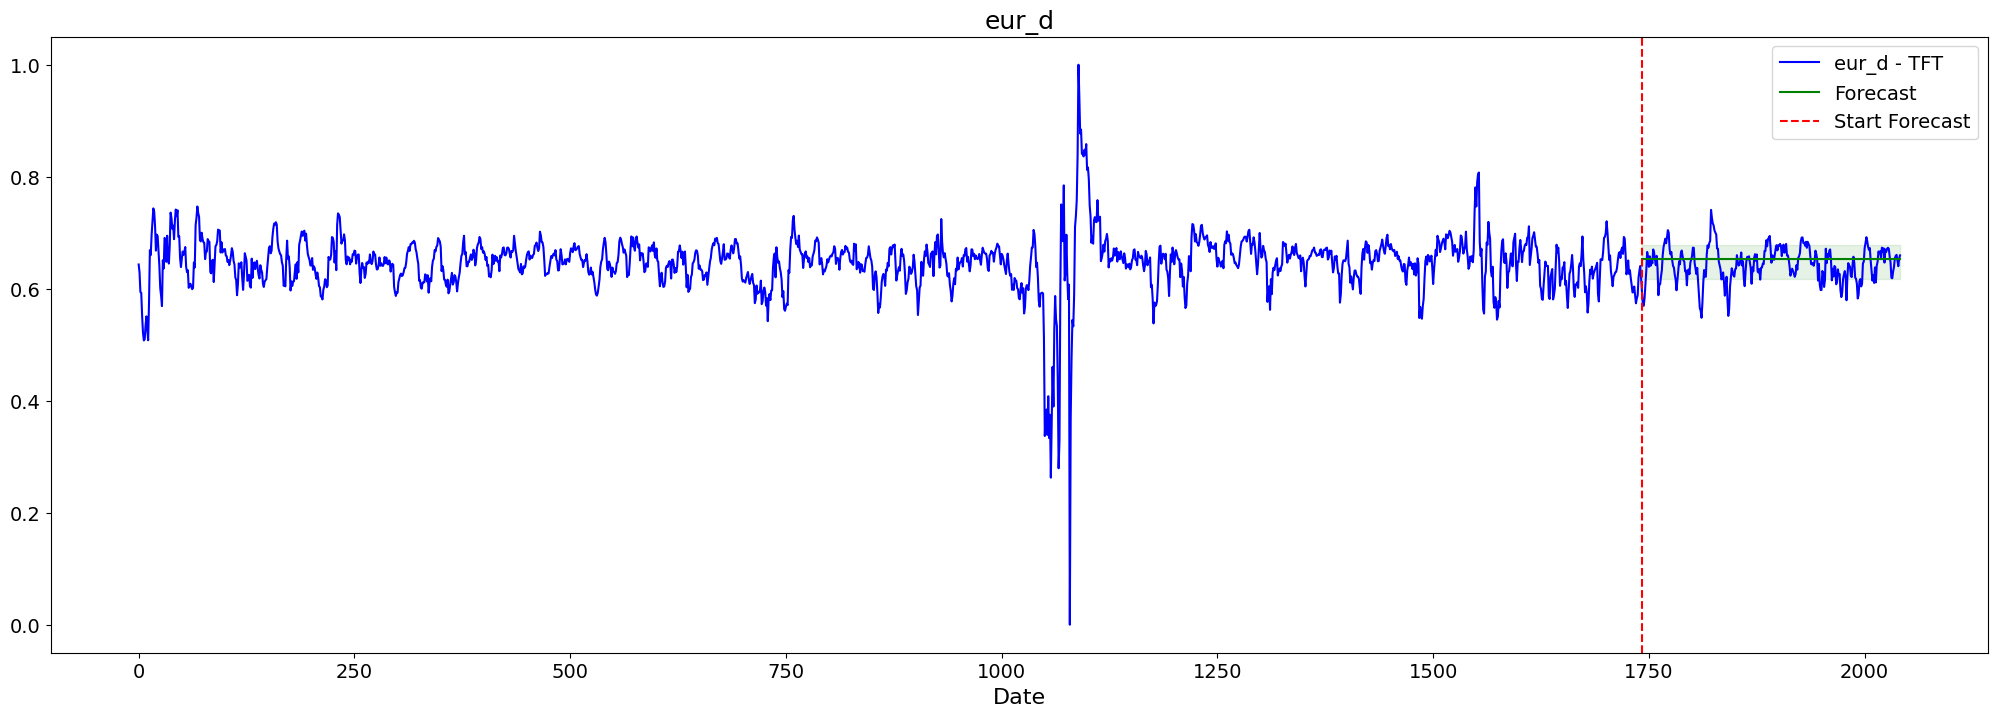

In [11]:
# Gráfico - Série Completa
ts = tss[0]
forecast = forecasts[0]

# Convertendo os índices para Timestamp se eles forem Period
ts_index = df.index.to_timestamp() if isinstance(df.index, pd.PeriodIndex) else df.index

# A previsão começa imediatamente após o último ponto de dados de teste
forecast_start_date = df.index[-prediction_length]

# Aqui estamos assumindo que ts_index é um pandas DatetimeIndex e ts.values são os valores correspondentes.
ts_index_from_forecast = ts_index[ts_index >= forecast_start_date]
ts_values_from_forecast = ts.values[ts_index >= forecast_start_date]

# Plotagem dos dados reais (treino + teste)
plt.figure(figsize=(25, 8))
plt.plot(ts_index, ts.values, label='eur_d - TFT', color='blue')

# Plotagem das previsões
prediction_intervals = (50.0, 90.0)
for pi in prediction_intervals:
    low, high = forecast.quantile(0.01 * (100 - pi)), forecast.quantile(0.01 * pi)
    plt.fill_between(
        ts_index_from_forecast,
        low,
        high,
        alpha=0.1,
        color="g"
    )

plt.plot(ts_index_from_forecast, forecast.mean, label='Forecast', color='g')

# Linha vertical para indicar o início da previsão
plt.axvline(forecast_start_date, color='r', linestyle='--', label='Start Forecast')

plt.title('eur_d')
plt.xlabel('Date')
#plt.ylabel('Valor')
plt.legend()
plt.show()

The mean prediction is not stored in the forecast data; the median is being returned instead. This behaviour may change in the future.


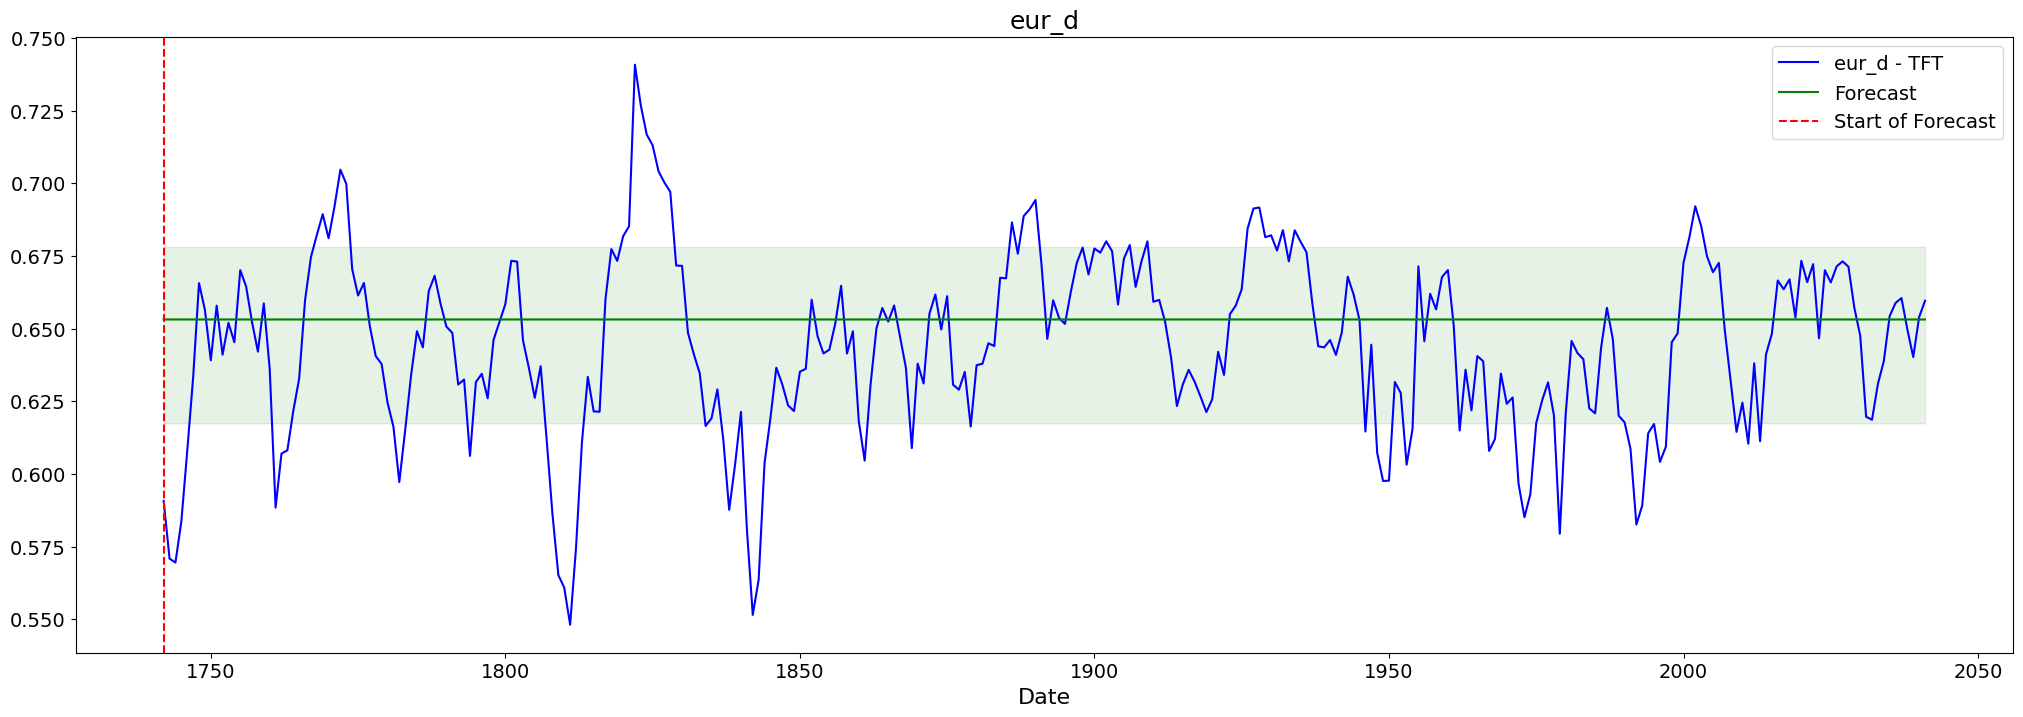

In [12]:
# Gráfico - Forecast
ts = tss[0]
forecast = forecasts[0]

# Convertendo os índices para Timestamp se eles forem Period
ts_index = df.index.to_timestamp() if isinstance(df.index, pd.PeriodIndex) else df.index

# A previsão começa imediatamente após o último ponto de dados de teste
forecast_start_date = df.index[-prediction_length]

# Restringir ts_index e ts.values para o período a partir de forecast_start_date
# Aqui estamos assumindo que ts_index é um pandas DatetimeIndex e ts.values são os valores correspondentes.
ts_index_from_forecast = ts_index[ts_index >= forecast_start_date]
ts_values_from_forecast = ts.values[ts_index >= forecast_start_date]

# Plotagem dos dados reais (treino + teste) a partir de forecast_start_date
plt.figure(figsize=(25, 8))
plt.plot(ts_index_from_forecast, ts_values_from_forecast, label='eur_d - TFT', color='blue')

# Plotagem das previsões
prediction_intervals = (50.0, 90.0)
for pi in prediction_intervals:
    low, high = forecast.quantile(0.01 * (100 - pi)), forecast.quantile(0.01 * pi)
    plt.fill_between(
        ts_index_from_forecast,
        low,
        high,
        alpha=0.1,
        color="g"
    )

plt.plot(ts_index_from_forecast, forecast.mean, label='Forecast', color='g')

# Linha vertical para indicar o início da previsão
plt.axvline(forecast_start_date, color='r', linestyle='--', label='Start of Forecast')

plt.title('eur_d')
plt.xlabel('Date')
plt.legend()
plt.show()

## DeepNPTS

In [13]:
str_time_dnpts = time.time()

dnptsModel = DeepNPTSEstimator(
        freq = "D",
        prediction_length = prediction_length,
        context_length = prediction_length,
        batch_norm = False,
        use_feat_static_cat = False,
        num_feat_static_real = 0,
        num_feat_dynamic_real = 0,
        lr = 1e-2,
        epochs = 50,
        dropout_rate =0.0,
        batch_size =24,
        num_batches_per_epoch = 50,
        cache_data = False,
    )
#Predição do modelo
dnpts = dnptsModel.train(train_ds)

# Evolução do modelo
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,  # test dataset
    predictor=dnpts,  # predictor
    num_samples=prediction_length,  # number of sample paths we want for evaluation
)

forecasts = list(forecast_it)
tss = list(ts_it)

evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts))

Loss for epoch 0: 0.009383114730007946
Loss for epoch 1: 0.004997673809994012
Loss for epoch 2: 0.004449660398531705
Loss for epoch 3: 0.004766799644567072
Loss for epoch 4: 0.0030241301842033864
Loss for epoch 5: 0.0028754836961161346
Loss for epoch 6: 0.003828165667364374
Loss for epoch 7: 0.003045653540175408
Loss for epoch 8: 0.0027259342628531157
Loss for epoch 9: 0.0029731162241660057
Loss for epoch 10: 0.0029887062474153936
Loss for epoch 11: 0.003278165985830128
Loss for epoch 12: 0.003041517995297909
Loss for epoch 13: 0.0029590165289118888
Loss for epoch 14: 0.003080098391510546
Loss for epoch 15: 0.003216552964877337
Loss for epoch 16: 0.0031483117130119355
Loss for epoch 17: 0.0028710979816969485
Loss for epoch 18: 0.0028690974204801023
Loss for epoch 19: 0.0030515785107854752
Loss for epoch 20: 0.002823864973615855
Loss for epoch 21: 0.0031175201060250402
Loss for epoch 22: 0.0030993774323724212
Loss for epoch 23: 0.00305633120238781
Loss for epoch 24: 0.002947056604316458

Running evaluation: 1it [00:00, 250.54it/s]


In [14]:
time_dnpts = time.time() - str_time_dnpts
nrmse_dnpts = agg_metrics['NRMSE']
smape_dnpts = agg_metrics['sMAPE']
mase_dnpts = agg_metrics['MASE']

print(nrmse_dnpts)
print(smape_dnpts)
print(mase_dnpts)
print(time_dnpts)


result_eur_d.loc[len(result_eur_d)] = [
    'DNPTS',time_dnpts, nrmse_dnpts, smape_dnpts, mase_dnpts
]

0.06381648999331191
0.053737061818440755
2.20230721120678
29.3882257938385


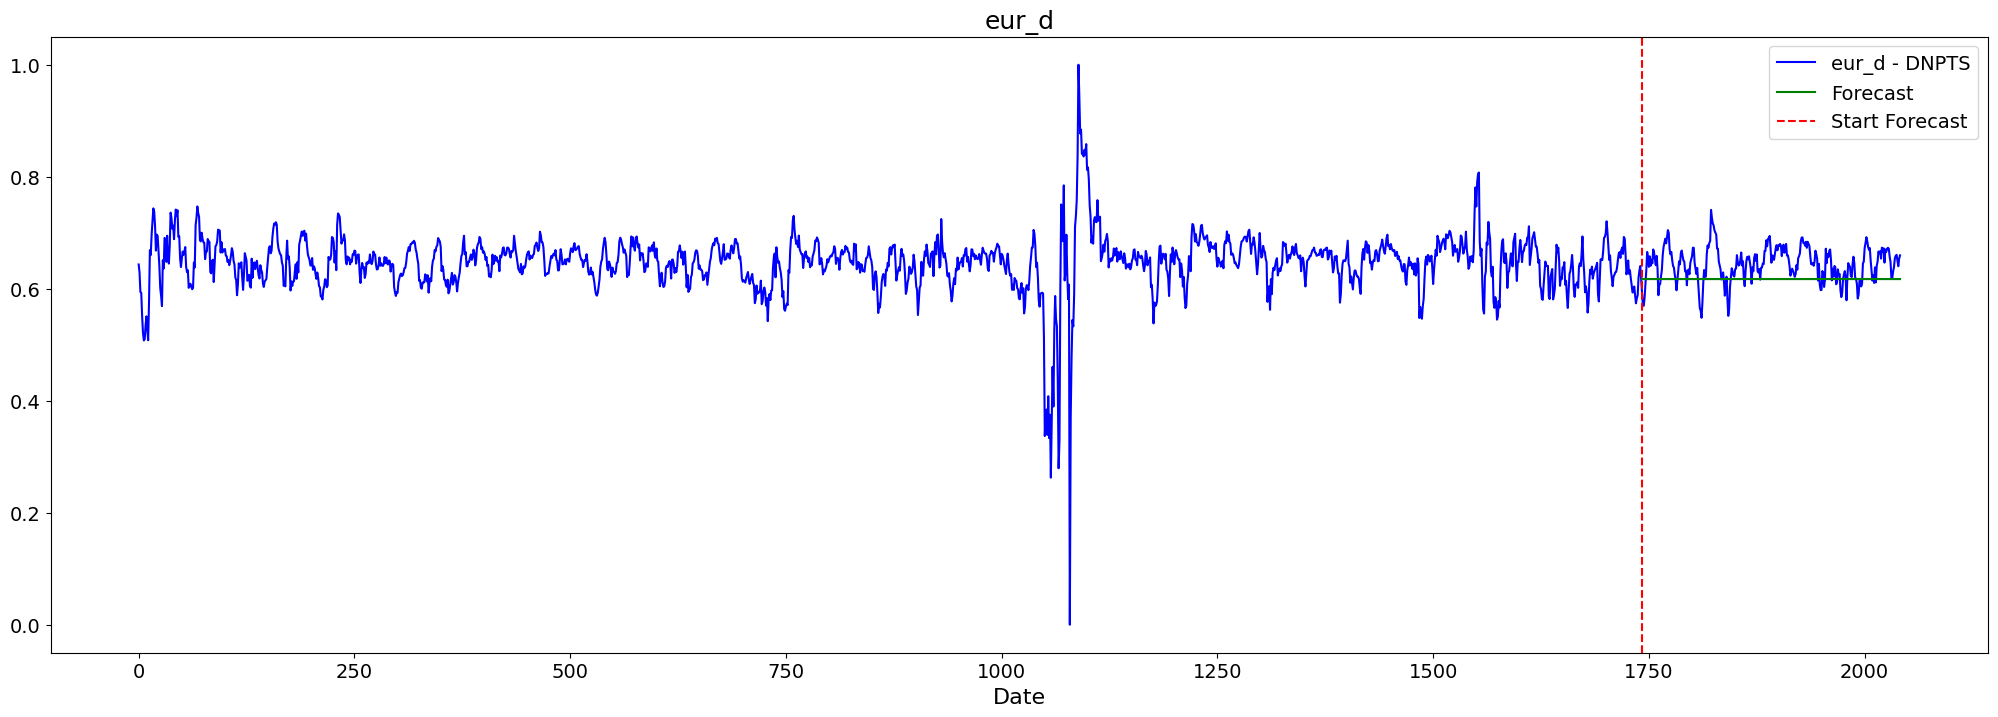

In [15]:
# Gráfico - Série Completa
ts = tss[0]
forecast = forecasts[0]

# Convertendo os índices para Timestamp se eles forem Period
ts_index = df.index.to_timestamp() if isinstance(df.index, pd.PeriodIndex) else df.index

# A previsão começa imediatamente após o último ponto de dados de teste
forecast_start_date = df.index[-prediction_length]

# Aqui estamos assumindo que ts_index é um pandas DatetimeIndex e ts.values são os valores correspondentes.
ts_index_from_forecast = ts_index[ts_index >= forecast_start_date]
ts_values_from_forecast = ts.values[ts_index >= forecast_start_date]

# Plotagem dos dados reais (treino + teste)
plt.figure(figsize=(25, 8))
plt.plot(ts_index, ts.values, label='eur_d - DNPTS', color='blue')

# Plotagem das previsões
prediction_intervals = (50.0, 90.0)
for pi in prediction_intervals:
    low, high = forecast.quantile(0.01 * (100 - pi)), forecast.quantile(0.01 * pi)
    plt.fill_between(
        ts_index_from_forecast,
        low,
        high,
        alpha=0.1,
        color="g"
    )

plt.plot(ts_index_from_forecast, forecast.mean, label='Forecast', color='g')

# Linha vertical para indicar o início da previsão
plt.axvline(forecast_start_date, color='r', linestyle='--', label='Start Forecast')

plt.title('eur_d')
plt.xlabel('Date')
#plt.ylabel('Valor')
plt.legend()
plt.show()

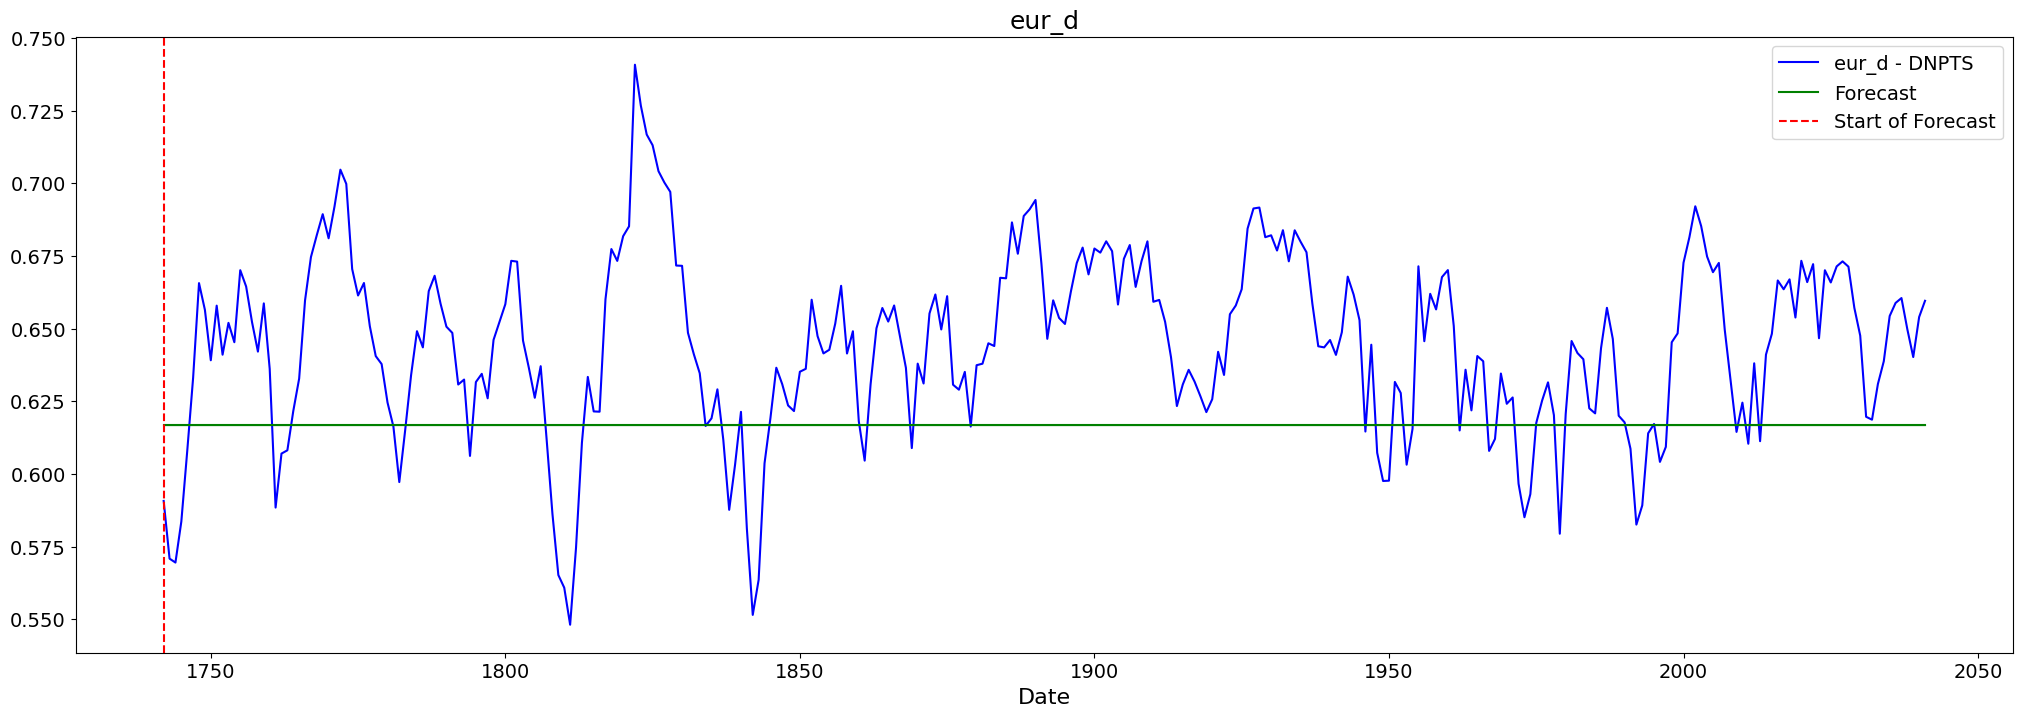

In [16]:
# Gráfico - Forecast
ts = tss[0]
forecast = forecasts[0]

# Convertendo os índices para Timestamp se eles forem Period
ts_index = df.index.to_timestamp() if isinstance(df.index, pd.PeriodIndex) else df.index

# A previsão começa imediatamente após o último ponto de dados de teste
forecast_start_date = df.index[-prediction_length]

# Restringir ts_index e ts.values para o período a partir de forecast_start_date
# Aqui estamos assumindo que ts_index é um pandas DatetimeIndex e ts.values são os valores correspondentes.
ts_index_from_forecast = ts_index[ts_index >= forecast_start_date]
ts_values_from_forecast = ts.values[ts_index >= forecast_start_date]

# Plotagem dos dados reais (treino + teste) a partir de forecast_start_date
plt.figure(figsize=(25, 8))
plt.plot(ts_index_from_forecast, ts_values_from_forecast, label='eur_d - DNPTS', color='blue')

# Plotagem das previsões
prediction_intervals = (50.0, 90.0)
for pi in prediction_intervals:
    low, high = forecast.quantile(0.01 * (100 - pi)), forecast.quantile(0.01 * pi)
    plt.fill_between(
        ts_index_from_forecast,
        low,
        high,
        alpha=0.1,
        color="g"
    )

plt.plot(ts_index_from_forecast, forecast.mean, label='Forecast', color='g')

# Linha vertical para indicar o início da previsão
plt.axvline(forecast_start_date, color='r', linestyle='--', label='Start of Forecast')

plt.title('eur_d')
plt.xlabel('Date')
plt.legend()
plt.show()

## Modelos Estatísticos

In [17]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import pmdarima as pm
import numpy as np

# Carregar o arquivo
df = pd.read_excel('oil_daily.xlsx')

# Separar a coluna 'date' para evitar escalá-la
dates = df['date']
df_numeric = df.drop(columns=['date'])

# Aplicar o scaler apenas nas colunas numéricas
scaler = MinMaxScaler()
df_pre = pd.DataFrame(scaler.fit_transform(df_numeric), columns=df_numeric.columns)

# Adicionar de volta a coluna 'date'
df_pre['date'] = dates

# Filtrando apenas as colunas relevantes e removendo os NaN
ddf = df_pre[['date', 'eur_d_diff']].dropna()

# Preparando os dados para o ListDataset
df_input = ddf['eur_d_diff'].to_numpy()

# Filtrando apenas a coluna 'eur_d_diff' e removendo os NaN
eur_d_diff = df[['eur_d_diff']].dropna()

# Definindo o percentual de divisão entre treino e teste
train_size = int(len(eur_d_diff) * 0.75)

# Dividindo entre treino e teste (somente a série temporal univariada)
train, test = eur_d_diff[:train_size], eur_d_diff[train_size:]

# Convertendo train e test para arrays unidimensionais (necessário para o ARIMA)
train = train['eur_d_diff'].values
test = test['eur_d_diff'].values

### ARIMA

In [18]:
str_time_ar = time.time()
# Função para calcular SMAPE (Symmetric Mean Absolute Percentage Error)
def smape(y_true, y_pred):
    return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

# Função para calcular MASE (Mean Absolute Scaled Error)
def mase(training_series, testing_series, prediction_series):
    n = training_series.shape[0]
    d = np.abs(np.diff(training_series)).sum() / (n - 1)
    errors = np.abs(testing_series - prediction_series)
    return errors.mean() / d

# Função para calcular MSIS (Mean Scaled Interval Score) - considerando uma previsão pontual
# Se for necessário aplicar para intervalos de confiança, será necessário o IC.
def msis(train, test, forecast, alpha=0.05):
    # MSIS é geralmente usada para intervalos de previsão (não apenas valores pontuais)
    # Aqui, simplificamos com um esqueleto de aplicação para uma previsão pontual
    q = alpha / 2
    return mase(train, test, forecast)  # Simplificação para previsão pontual

# Ajuste do modelo ARIMA com ajuste automático
model_arima = pm.auto_arima(train, seasonal=True, m=12)

# Prevendo para o período de teste
pred_arima = model_arima.predict(n_periods=len(test))

# Cálculo das métricas
time_ar = time.time() - str_time_ar
mae_ar = mean_absolute_error(test, pred_arima)
mse_ar = mean_squared_error(test, pred_arima)
rmse_ar = np.sqrt(mse_ar)
nrmse_ar = rmse_ar / (test.max() - test.min())
smape_value_ar = smape(test, pred_arima) / 100
mase_value_ar = mase(train, test, pred_arima)


# Exibir as métricas
print(f"NRMSE: {nrmse_ar}")
print(f"SMAPE: {smape_value_ar}")
print(f"MASE: {mase_value_ar}")

result_eur_d.loc[len(result_eur_d)] = [
    'ARIMA',time_ar, nrmse_ar, smape_value_ar, mase_value_ar
]

NRMSE: 0.13861124240441622
SMAPE: 1.9700967586481166
MASE: 1.8410046191161507


### Exponential Smoothing

In [21]:
str_time_es = time.time()
# Função para calcular SMAPE (Symmetric Mean Absolute Percentage Error)
def smape(y_true, y_pred):
    return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

# Função para calcular MASE (Mean Absolute Scaled Error)
def mase(training_series, testing_series, prediction_series):
    n = training_series.shape[0]
    d = np.abs(np.diff(training_series)).sum() / (n - 1)
    errors = np.abs(testing_series - prediction_series)
    return errors.mean() / d

# Função para calcular MSIS (Mean Scaled Interval Score) - considerando uma previsão pontual
def msis(train, test, forecast, alpha=0.05):
    # MSIS é geralmente usada para intervalos de previsão (não apenas valores pontuais)
    # Aqui, simplificamos com um esqueleto de aplicação para uma previsão pontual
    q = alpha / 2
    return mase(train, test, forecast)  # Simplificação para previsão pontual

# Ajuste do modelo Exponential Smoothing
model_exp_smoothing = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=12).fit()

# Prevendo para o período de teste
pred_exp_smoothing = model_exp_smoothing.forecast(len(test))

# Cálculo das métricas
time_es = time.time() - str_time_es
mae_es = mean_absolute_error(test, pred_exp_smoothing)
mse_es = mean_squared_error(test, pred_exp_smoothing)
rmse_es = np.sqrt(mse_es)
nrmse_es = rmse_es / (test.max() - test.min())
smape_value_es = smape(test, pred_exp_smoothing) / 100
mase_value_es = mase(train, test, pred_exp_smoothing)

# Exibir as métricas
print(f"NRMSE: {nrmse_es}")
print(f"SMAPE: {smape_value_es}")
print(f"MASE: {mase_value_es}")

result_eur_d.loc[len(result_eur_d)] = [
    'Exp. Smoothing',time_es, nrmse_es, smape_value_es, mase_value_es
]

NRMSE: 0.14346172093929058
SMAPE: 1.5669931332960718
MASE: 1.9281977025568664


## Results

In [22]:
result_eur_d

,Modelo,TIME,NRMSE,SMAPE,MASE
0,SSF,32.911070,0.049554,0.039425,1.626727
1,TFT,172.025303,0.049664,0.038756,1.600061
2,DNPTS,29.388226,0.063816,0.053737,2.202307
3,ARIMA,64.330841,0.138611,1.970097,1.841005
4,Exp. Smoothing,0.236887,0.143462,1.566993,1.928198


In [23]:
# Função para calcular as pontuações
def calc_rank(coluna):
    coluna_rank = coluna.rank(ascending=True, method='min')
    coluna_rank_max = len(coluna) + 1  # Pontuação máxima
    pontuacao = coluna_rank_max - coluna_rank
    return pontuacao.astype(int)

# Supondo que você já tenha um DataFrame chamado result_eur_d
result_eur_d['NRMSE_scr'] = calc_rank(result_eur_d['NRMSE'])
result_eur_d['SMAPE_scr'] = calc_rank(result_eur_d['SMAPE'])
result_eur_d['MASE_scr'] = calc_rank(result_eur_d['MASE'])

# Calcular a pontuação total
result_eur_d['TOTAL_scr'] = result_eur_d['NRMSE_scr']  + result_eur_d['SMAPE_scr'] + result_eur_d['MASE_scr']

# Ordenar o DataFrame pelo valor da coluna 'TOTAL_scr'
result_eur_d = result_eur_d.sort_values(by='TOTAL_scr', ascending=False)


In [24]:
result_eur_d

,Modelo,TIME,NRMSE,SMAPE,MASE,NRMSE_scr,SMAPE_scr,MASE_scr,TOTAL_scr
1,TFT,172.025303,0.049664,0.038756,1.600061,4,5,5,14
0,SSF,32.911070,0.049554,0.039425,1.626727,5,4,4,13
2,DNPTS,29.388226,0.063816,0.053737,2.202307,3,3,1,7
3,ARIMA,64.330841,0.138611,1.970097,1.841005,2,1,3,6
4,Exp. Smoothing,0.236887,0.143462,1.566993,1.928198,1,2,2,5


In [25]:
# Exportar os resultados para XLSX
result_path = 'result/'
excel_file_path = os.path.join(result_path, 'model_results.xlsx')
if os.path.exists(excel_file_path):
    try:
        with pd.ExcelWriter(excel_file_path, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
            result_eur_d.to_excel(writer, sheet_name='eur_d', index=False)
    except Exception as e:
        print(f"Erro ao adicionar folha 'eur_d': {e}")
else:
    with pd.ExcelWriter(excel_file_path, engine='openpyxl', mode='w') as writer:
        result_eur_d.to_excel(writer, sheet_name='eur_d', index=False)